### Dependencies

In [1]:
import random
import os
from glob import glob 

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torchaudio
import torchmetrics as tm
import torchmetrics.classification as tm_cls
import torch

from dataset import VADMelDataModule
from inference import VADPredictor
from utils.load_config import load_config
from utils.get_frame_targets import get_frame_targets
from utils.evaluating import plotly_plot_roc

from IPython.display import Image, display

Constants

In [2]:
EPS = 1e-8
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# np.random.seed(42)

paths = {'sample':'data/samples/5ed8a1c0f3ea2.flac',
        'config_name': '32_n_frames.yml',
        'ckpt_folder': 'checkpoints/32_n_frames',
        'weight_folder': 'weights/VADNet_30_0.0281_0.9889.pt'}

glob_paths = {}

Params

In [3]:
cfg = load_config('./configs/' + paths['config_name'])
params = {key: value for key, value in cfg['data'].items()}

Model

In [4]:
predictor = VADPredictor(ckpt_folder = paths['ckpt_folder'], weight_folder = paths['weight_folder'], device=device)
mel_spec =  torchaudio.transforms.MelSpectrogram(n_fft=params['nfft'], hop_length=params['hop_length'], n_mels=params['n_mels'])

### ROC - curve. AUROC. For samples.

In [5]:
params['n_workers'] = 10

In [6]:
datamodule = VADMelDataModule(**params).setup(info = False)
test_dataloader = datamodule.test_dataloader()
model = predictor.get_model()

In [7]:
metrics = {m: getattr(tm_cls, m)(thresholds = None).to(device) for m in ['BinaryROC', 'BinaryAUROC']}

In [8]:
for inputs, labels in tqdm(test_dataloader):
    inputs, targets = inputs.to(device), labels.to(device).long()  
    with torch.no_grad():
        preds = model(inputs).transpose(1, 2)
    for m in metrics.keys():
        metrics[m].update(preds=preds, target=targets)

100%|███████████████████████████████████████████████████████████████████████████| 190/190 [01:55<00:00,  1.65it/s]


In [9]:
auc_value = metrics['BinaryAUROC'].compute().item()
print('AUC: ', auc_value) # auc

AUC:  0.9994974136352539


In [10]:
fprs, tprs, thresholds =  metrics['BinaryROC'].compute() # roc

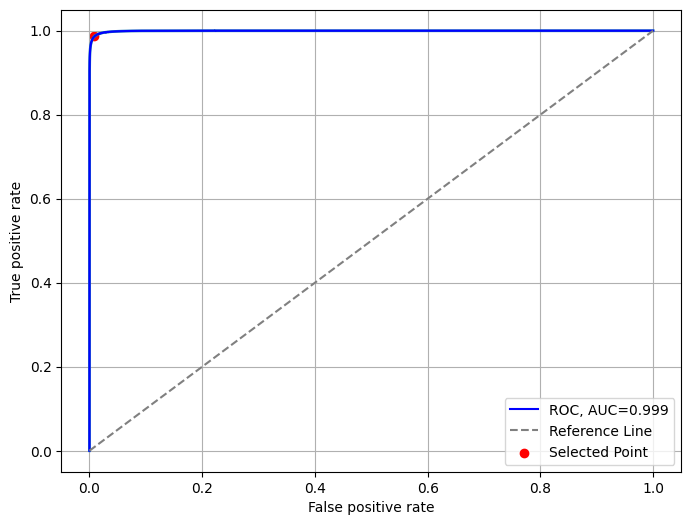

In [12]:
bn_roc = tm_cls.BinaryROC(thresholds = None).to(device)
fig, _ax = bn_roc.plot(curve = (fprs, tprs, thresholds), score = True)
fig.set_size_inches(8, 6)
_ax.plot(fprs.cpu(), tprs.cpu(), label=f"ROC, AUC={auc_value:.3f}", color="blue") # plot above 

_ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label = 'Reference Line')
desired_fpr_val = 0.008
desired_tpr_val = 0.987
_ax.scatter([desired_fpr_val], [desired_tpr_val], color="red", label="Selected Point")

# red line
# _ax.plot(
#     [desired_fpr_val, desired_fpr_val],  # Ось X остается фиксированной
#     [0, desired_tpr_val],  # Ось Y: от 0 до нужного TPR
#     color="red",
#     linestyle="--",
#     linewidth=1.2,
# )

_ax.legend(loc = 'lower right')
plt.title('') # убрал binary - roc 
plt.savefig('pics/Finally_roc_auc_curve')
plt.show()

In [12]:
threshold_index = np.argmin(np.abs(fprs.cpu() - desired_fpr_val) + np.abs(tprs.cpu() - desired_tpr_val))
print('Threshold index for desired fpr and tpr:', threshold_index.item())
print('Threshold:', thresholds[threshold_index].item())

Threshold index for desired fpr and tpr: 166330
Threshold: 0.6183742880821228


##### Without usign dataloader

In [ ]:
samples = glob(os.path.join(str(params['data_dir']), '*.flac'))

seed = 42
samples = glob(os.path.join(str(params['data_dir']), '*.flac'))
train_len = int(len(samples) * params['train_percent'])
valid_len = int(len(samples) * params['valid_percent'])
random.seed(seed)
np.random.seed(seed)
random.shuffle(samples)
test_set = samples[train_len + valid_len:]

bn_roc = tm_cls.BinaryROC(thresholds = None).to(device)
bn_auroc = tm_cls.BinaryAUROC(thresholds = None).to(device)

for t in tqdm(test_set):
    t = t.replace('\\', '/')
    audio, _ = torchaudio.load(t)
    spec = torch.log(mel_spec(audio) + EPS)
    total_frames = spec.shape[-1]
    pred = torch.from_numpy(predictor.predict(audio_path = t, threshold = None))
    target = get_frame_targets(t, total_frames=total_frames, hop_length=params['hop_length']).squeeze(0).to(torch.long)
    with torch.no_grad():
        bn_roc.update(preds=pred, target=target) # roc
        bn_auroc.update(preds=pred, target=target) # auc

auc_value = bn_auroc.compute().item()
print('AUC: ', auc_value) # auc

fprs, tprs, thresholds = bn_roc.compute() # roc
fig, _ax = bn_roc.plot(curve = (tpr, fpr, thresholds), score = True)
_ax_task.plot([0, 1], [0, 1], linestyle='--', color='red')
# plots
# plotly_plot_roc(fprs, tprs, auc_value, desire_fr_val_i=0.08, desire_tr_val_i=0.93, vertical_line=True) 
# do not plot to upload to git
display(Image(filename='pics/roc-curve-for-samples.png'))
desire_fr_val = 0.08
desire_tr_val = 0.93
threshold_index = np.argmin(np.abs(fprs - desire_fr_val) + np.abs(tprs - desire_tr_val))
print('Threshold index for desired fpr and tpr:', threshold_index.item())
print('Threshold:', thresholds[threshold_index].item())

### Inferencing 

In [2]:
# Path to sample: data/samples/5ed8a1c0f3ea2.flac
# Threshold: 0.62
# Path to checkpoints: checkpoints/current_run
# Path to weights: weights/VADNet_13_0.1502_0.9506.pt   
!python inference.py data/samples/5ed8a1c0f3ea2.flac -plot -s -t 0.62 -c checkpoints/32_n_frames -w weights/VADNet_30_0.0281_0.9889.pt  

Результат сохранён в файл: pics/result.png
Figure(1000x600)


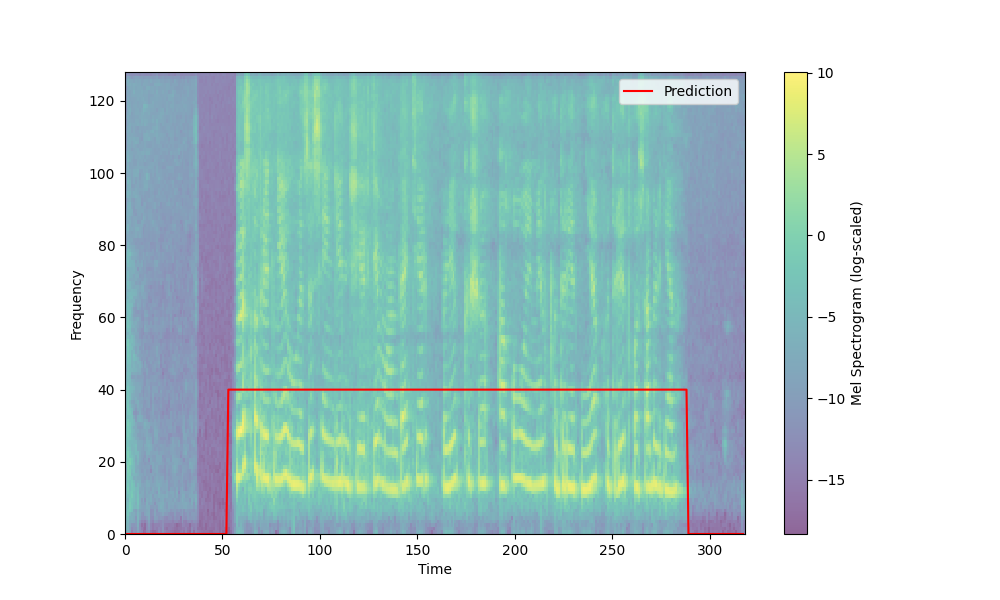

In [3]:
display(Image(filename='pics/result.png'))

### Metrics.

In [5]:
threshold = 0.62 
params['n_workers'] = 10

In [6]:
datamodule = VADMelDataModule(**params).setup(info = False)
test_dataloader = datamodule.test_dataloader()
model = predictor.get_model()

In [7]:
metrics = {m: getattr(tm_cls, m)(threshold = threshold, validate_args=True).to(device) for m in ['BinaryAccuracy', 'BinaryPrecision', 'BinaryRecall', 'BinaryF1Score']}

In [8]:
for inputs, labels in tqdm(test_dataloader):
    inputs, targets = inputs.to(device), labels.to(device)
    with torch.no_grad():
        preds = model(inputs).transpose(1, 2)    
    for m in metrics.keys():
        metrics[m].update(preds=preds, target=targets) 

100%|███████████████████████████████████████████████████████████████████████████████████████████| 190/190 [01:49<00:00,  1.74it/s]


In [9]:
computed_metrics = {m: metrics[m].compute().item() for m in metrics.keys()}
_ = [metrics[m].reset() for m in metrics.keys()]

In [10]:
_ = [print(f"{m}: {computed_metrics[m]:.4f} ", end="") for m in metrics.keys()]

BinaryAccuracy: 0.9886 BinaryPrecision: 0.9929 BinaryRecall: 0.9869 BinaryF1Score: 0.9899 

### Saving, ploting metrics

In [1]:
from utils.evaluating import save_graph_tb_log_metrics

График сохранён в pics/Loss_Train_Val_32_epoch.png


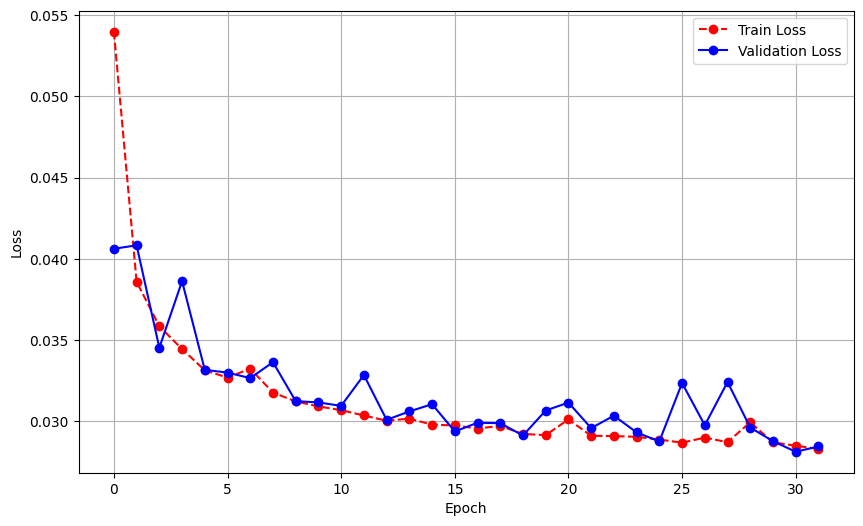

In [3]:
save_graph_tb_log_metrics(
    first_csv_path='C:/Users/b.smadiarov/Downloads/Loss_Train.csv',
    second_csv_path='C:/Users/b.smadiarov/Downloads/Loss_Validation.csv',
    name_ox='Epoch',
    name_oy='Loss',
    loc = 'upper right',
    pth_save='pics/Loss_Train_Val_32_epoch.png'
)

### Comparing: MarbleNet vs VadNet

In [11]:
# Todo